# Import lib

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
# The latest CDF library https://spdf.gsfc.nasa.gov/pub/software/cdf/dist/latest/
from spacepy import pycdf

# os.environ["CDF_LIB"] = "C:\\Program Files\\CDF_Distribution\\cdf39_0-dist\\lib"
os.environ["CDF_LIB"] = "/Applications/cdf/cdf39_0-dist/lib"

# sys.path.append('../lib/')
sys.path.append('./lib/')

import juice_cdf_lib as juice_cdf

# Setting and Read CDF file

In [3]:
# *** Parameter set ***
spec_mode = 1                           # 0: low-resoltion   1: high-resolution
hz_mode = 1                             # 0: sum    1: /Hz
cal_mode = 0                            # 0: raw    1: dBm＠ADC  2: V@ADC   3:V2@ADC    4: V2/Hz@ADC
cal = 0                                 # 0: background   1: cal
clean_mode = 0                          # 0: normal 1: noise cleaning

# E_power_min = 1e-4                      # E_power_min: 10e-4 (--> -144 dBm)
f_max = 45000                           # f_max [kHz]
f_min = 80                              # f_min [kHz]
p_max = 9.0                             # background: 8   CAL: 10
p_min = 2.0                             # background: 2   CAL: 5

cf = 0.0                                # Conversion Factor: RAW
if cal_mode == 1:
    cf = -104.1                         # dBm @ ADC input
elif cal_mode == 2:
    cf = -104.1 - 10.00                 # V @ ADC input
elif cal_mode == 3:
    cf = -104.1 - 13.01                 # V^2 @ ADC input

"""
* Conversion Factor
    0 dB @ RAW   ==>  -104.1 dBm    @ ADC input
                 ==>  -114.1 dB V  = 1.97E-6 V
                 ==>  -117.1 dB v2 = 1.40E-6 Vrms
                 
    (ref)   +-1 V (2Vpp, 0dB V) -->  1(V) * 1(V) / 50(ohm) / 2 * 1000 (mW) = 10 mW (+10 dBm)
            = 0.707 Vrms (-3.01 dB Vrms)
            ==> 0dB V  =  -3.01 dB Vrms  =  +10 dBm
            
* SG @ EM2-0       5.50 MHz, 0.01 Vpp   X-ch:90deg, Y-ch:0deg, Z-ch:0deg        impedance: 50Ω 
    +-13000  ==>    3.85E
                    +-0.01240 V -->   0.024 Vpp ??]
    [+-13000  ==> +-0.01240 V -->   0.024 Vpp ??]

* ADC input
    20-bit res  (1048576 [120.4 dB))   max 1.0 Vpp
                 ==>  1-bit:  9.54e-7 V [-120.4 dB V]
"""

p_max = p_max + cf/10
p_min = p_min + cf/10
if hz_mode == 1:
    p_max = p_max - 6.0
    p_min = p_min - 6.0
else:
    if spec_mode == 1:
        p_max = p_max - 3.0
        p_min = p_min - 3.0
    else:
        p_max = p_max - 4.0
        p_min = p_min - 4.0

# *** Folder set ***
work_dir = '/Users/user/0-python/JUICE_notebook/ql/'   # Plot dump folder
data_dir = '/Users/user/0-python/JUICE_GS_test/cdf/org/'   # Data folder

In [4]:
# *** NECP ***
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230419T135849-20230419T141229_V01___RPR1_52000000_2023.109.16.17.21.607.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230419T141231-20230419T141402_V01___RPR1_52000001_2023.109.17.51.54.600.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230530T100326-20230530T100925_V01___RPR1_52000010_2023.150.10.40.53.663.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230530T100927-20230530T100937_V01___RPR1_52000011_2023.150.10.41.53.508.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230530T100326-20230530T100925_V01___RPR1_52000010_2023.150.10.40.53.663.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T120759-20230601T120857_V01___RPR1_52000015_2023.152.12.32.12.471.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T121435-20230601T121533_V01___RPR1_52000016_2023.152.13.14.38.473.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T122138-20230601T122236_V01___RPR1_52000017_2023.152.13.55.02.539.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T122707-20230601T122805_V01___RPR1_52000018_2023.152.14.35.37.467.cdf'
data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T123416-20230601T123514_V01___RPR1_52000019_2023.152.15.15.55.483.cdf'

# *** High-samp rate ***
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000304-20000101T000308_V01___TMIDX_00000_32.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000150-20000101T000154_V01___TMIDX_00000_64.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000355-20000101T000359_V01___TMIDX_00000_96.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000555-20000101T000559_V01___TMIDX_00000_128.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000725-20000101T000730_V01___TMIDX_00000_256.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000131-20000101T000139_V01___TMIDX_00000_512.bin.cdf'
#
# data_name = 'bad_NEW_PROCESSING_JUICE_L1a_RPWI-HF-SID2_20000101T000114-20000101T000210_V01___TMIDX_00000.bin.cdf'

# *** High-samp rate: Tsuchiya ***
data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000050-20000101T000454_V01___HF_SID2_032_20230624-1132.ccs.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000031-20000101T000940_V01___HF_SID2_064_20230624-1139.ccs.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000111-20000101T000150_V01___HF_SID2_128_20230624-1306.ccs.cdf'

# *** Ver.2 ***
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000459-20000101T000700_V01___HF_20210920-1007.ccs.cdf'

cdf_file = data_dir + data_name
# %ls $data_dir
%ls $cdf_file

/Users/user/0-python/JUICE_GS_test/cdf/org/JUICE_L1a_RPWI-HF-SID2_20000101T000050-20000101T000454_V01___HF_SID2_032_20230624-1132.ccs.cdf


# get SID-2 data

In [5]:
cdf = pycdf.CDF(cdf_file)
data = juice_cdf.juice_getdata_hf_sid02(cdf)

# Raw data

2000/01/01


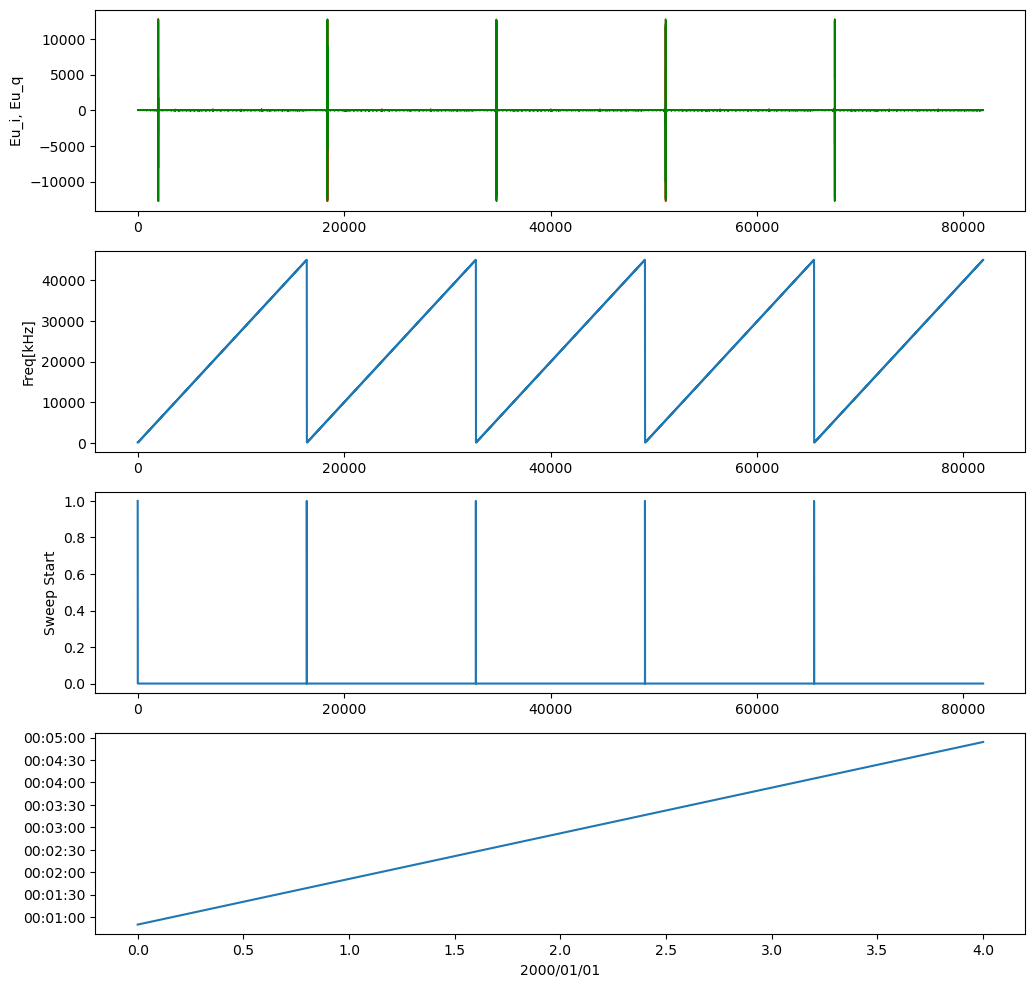

In [6]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2)
ax3 = fig.add_subplot(4, 1, 3)
ax4 = fig.add_subplot(4, 1, 4)

ax1.plot(np.ravel(data.Eu_i), '-r', linewidth=1)
ax1.plot(np.ravel(data.Eu_q), '-g', linewidth=1)
ax2.plot(np.ravel(data.frequency))
ax3.plot(np.ravel(data.sweep_start))
ax4.plot(np.ravel(data.epoch))
date = data.epoch[0]
date = date.strftime('%Y/%m/%d')
print(date)

ax1.set_ylabel('Eu_i, Eu_q')
ax2.set_ylabel('Freq[kHz]')
ax3.set_ylabel('Sweep Start')
ax4.set_xlabel(date)

# xlim=[458239, 458241]
# ax1.set_xlim(xlim)
# ax2.set_xlim(xlim)
# ax3.set_xlim(xlim)
# ylim=[-13000, -12000]
# ax1.set_ylim(ylim)
# ax2.set_ylim(ylim)
# ax3.set_ylim(ylim)
plt.show()
png_fname = work_dir+data_name+'_raw.png'
fig.savefig(png_fname)


In [7]:
# Sped mode:  0 - low resolution,  1 - high resolution  
spec = juice_cdf.juice_getspec_hf_sid02(data, spec_mode, hz_mode)
power_str = juice_cdf.power_label(cal_mode, hz_mode)

if clean_mode > 0:                          # 0: normal 1: noise cleaning
    spec.Eu_power = juice_cdf.clean_rfi(spec.Eu_power, 7)
    spec.Ev_power = juice_cdf.clean_rfi(spec.Ev_power, 7)
    spec.Ew_power = juice_cdf.clean_rfi(spec.Ew_power, 7)

spec.Eu_power = spec.Eu_power * 10**(cf/10)
spec.Ev_power = spec.Ev_power * 10**(cf/10)
spec.Ew_power = spec.Ew_power * 10**(cf/10)

freq_ave = np.mean(spec.frequency, axis=1)
Eu_ave = np.mean(spec.Eu_power, axis=1)
Ev_ave = np.mean(spec.Ev_power, axis=1)
Ew_ave = np.mean(spec.Ew_power, axis=1)

n_time = spec.Eu_power.shape[1]
n_freq = spec.Eu_power.shape[0]


# Spectra

# LOG: Frequency - Power

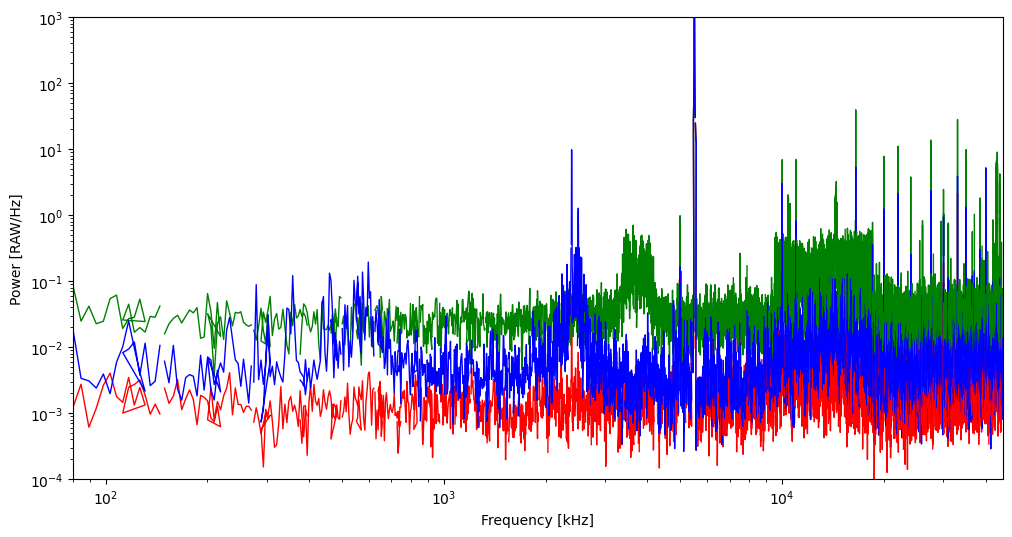

In [8]:
fig = plt.figure(figsize=(12, 6))

for i in range(spec.n_step):
    plt.plot(freq_ave[i*spec.n_samp:(i+1)*spec.n_samp], Eu_ave[i*spec.n_samp:(i+1)*spec.n_samp], '-r', linewidth=1)
    plt.plot(freq_ave[i*spec.n_samp:(i+1)*spec.n_samp], Ev_ave[i*spec.n_samp:(i+1)*spec.n_samp], '-g', linewidth=1)
    plt.plot(freq_ave[i*spec.n_samp:(i+1)*spec.n_samp], Ew_ave[i*spec.n_samp:(i+1)*spec.n_samp], '-b', linewidth=1)
    """
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0], spec.Eu_power[i*spec.n_samp:(i+1)*spec.n_samp,0], '--r', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0], spec.Ev_power[i*spec.n_samp:(i+1)*spec.n_samp,0], '--g', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0], spec.Ew_power[i*spec.n_samp:(i+1)*spec.n_samp,0], '--b', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], spec.Eu_power[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], ':r', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], spec.Ev_power[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], ':g', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], spec.Ew_power[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], ':b', linewidth=1)
    """
plt.xlabel('Frequency [kHz]')
plt.xscale('log')
plt.xlim(f_min, f_max)

plt.yscale('log')
plt.ylabel(power_str)
plt.ylim(10**p_min, 10**p_max)

plt.show()
png_fname = work_dir+data_name+'_spec-log.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_spec-log_h.png'
fig.savefig(png_fname)

# Linear: Frequency - Power diagram

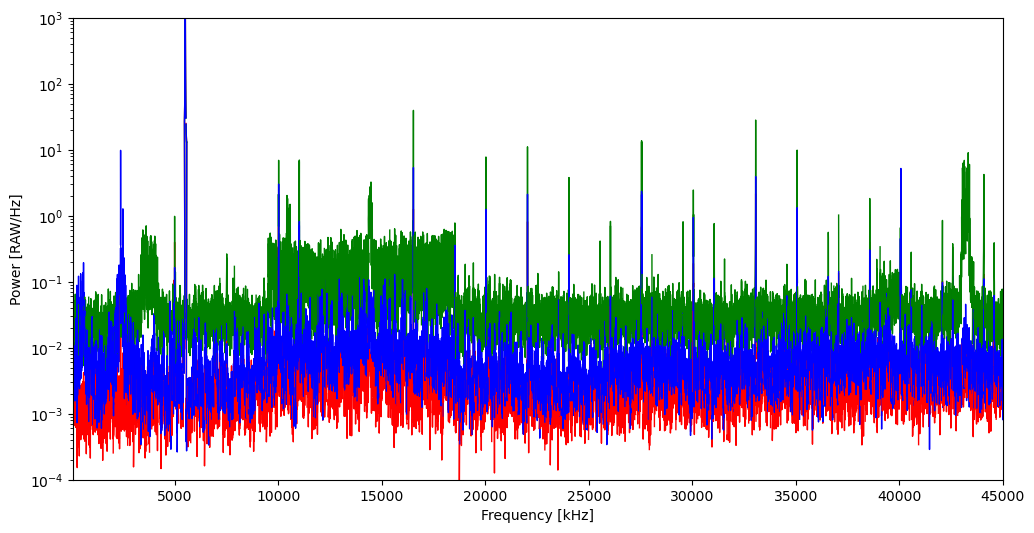

In [9]:
fig = plt.figure(figsize=(12, 6))

for i in range(spec.n_step):
    plt.plot(freq_ave[i*spec.n_samp:(i+1)*spec.n_samp], Eu_ave[i*spec.n_samp:(i+1)*spec.n_samp], '-r', linewidth=1)
    plt.plot(freq_ave[i*spec.n_samp:(i+1)*spec.n_samp], Ev_ave[i*spec.n_samp:(i+1)*spec.n_samp], '-g', linewidth=1)
    plt.plot(freq_ave[i*spec.n_samp:(i+1)*spec.n_samp], Ew_ave[i*spec.n_samp:(i+1)*spec.n_samp], '-b', linewidth=1)
    """
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0], spec.Eu_power[i*spec.n_samp:(i+1)*spec.n_samp,0], '--r', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0], spec.Ev_power[i*spec.n_samp:(i+1)*spec.n_samp,0], '--g', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0], spec.Ew_power[i*spec.n_samp:(i+1)*spec.n_samp,0], '--b', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], spec.Eu_power[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], ':r', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], spec.Ev_power[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], ':g', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], spec.Ew_power[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], ':b', linewidth=1)
    """
plt.xlabel('Frequency [kHz]')
plt.xlim(f_min, f_max)

plt.yscale('log')
plt.ylabel(power_str)
plt.ylim(10**p_min, 10**p_max)

plt.show()
png_fname = work_dir+data_name+'_spec.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_spec_h.png'
fig.savefig(png_fname)

# LOG: Frequency - Time diagram

/var/folders/h3/4_tnwr0x0v9gcl5qc0vczzyr0000gn/T/ipykernel_1866/3003852791.py:27: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p1 = ax1.pcolormesh(spec.epoch, spec.frequency, spec.Eu_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
/var/folders/h3/4_tnwr0x0v9gcl5qc0vczzyr0000gn/T/ipykernel_1866/3003852791.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p2 = ax2.pcolormesh(spec.epoch, spec.frequency, spec.Ev_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
/var/folders/h3/4_tnwr0x0v9gcl5qc0vczzyr0000gn/T/ipykernel_1866/3003852791.p

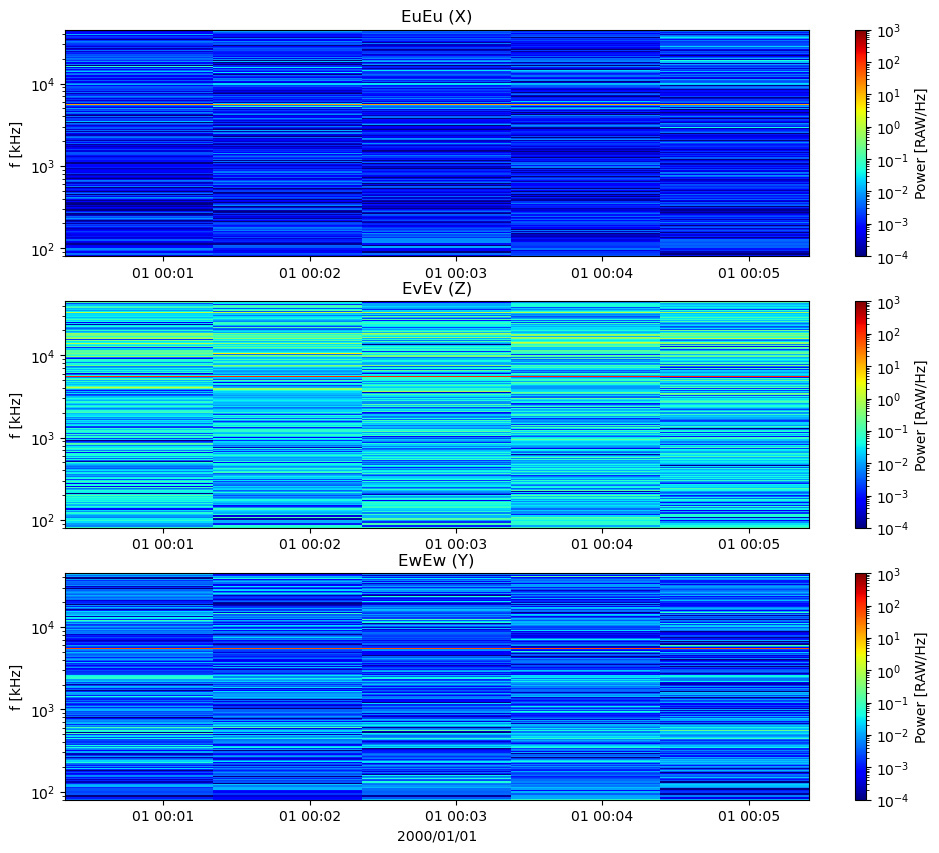

In [10]:
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

# Y-axis
ax1.set_ylim(f_min, f_max)
ax2.set_ylim(f_min, f_max)
ax3.set_ylim(f_min, f_max)
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax1.set_ylabel('f [kHz]')
ax2.set_ylabel('f [kHz]')
ax3.set_ylabel('f [kHz]')

# X-axis
ax1.set_title('EuEu (X)')
ax2.set_title('EvEv (Z)')
ax3.set_title('EwEw (Y)')
date = data.epoch[0]
date = date.strftime('%Y/%m/%d')
ax3.set_xlabel(date)

# Plot
p1 = ax1.pcolormesh(spec.epoch, spec.frequency, spec.Eu_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
p2 = ax2.pcolormesh(spec.epoch, spec.frequency, spec.Ev_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
p3 = ax3.pcolormesh(spec.epoch, spec.frequency, spec.Ew_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')

pp1 = fig.colorbar(p1, ax=ax1, orientation="vertical")
pp1.set_label(power_str)
pp2 = fig.colorbar(p2, ax=ax2, orientation="vertical")
pp2.set_label(power_str)
pp3 = fig.colorbar(p3, ax=ax3, orientation="vertical")
pp3.set_label(power_str)

png_fname = work_dir+data_name+'_FT-log.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_FT-log_h.png'
# fig.savefig(png_fname)


# Linear: Frequency - Time diagram

/var/folders/h3/4_tnwr0x0v9gcl5qc0vczzyr0000gn/T/ipykernel_1866/912218370.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p1 = ax1.pcolormesh(spec.epoch, spec.frequency, spec.Eu_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
/var/folders/h3/4_tnwr0x0v9gcl5qc0vczzyr0000gn/T/ipykernel_1866/912218370.py:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p2 = ax2.pcolormesh(spec.epoch, spec.frequency, spec.Ev_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
/var/folders/h3/4_tnwr0x0v9gcl5qc0vczzyr0000gn/T/ipykernel_1866/912218370.py:2

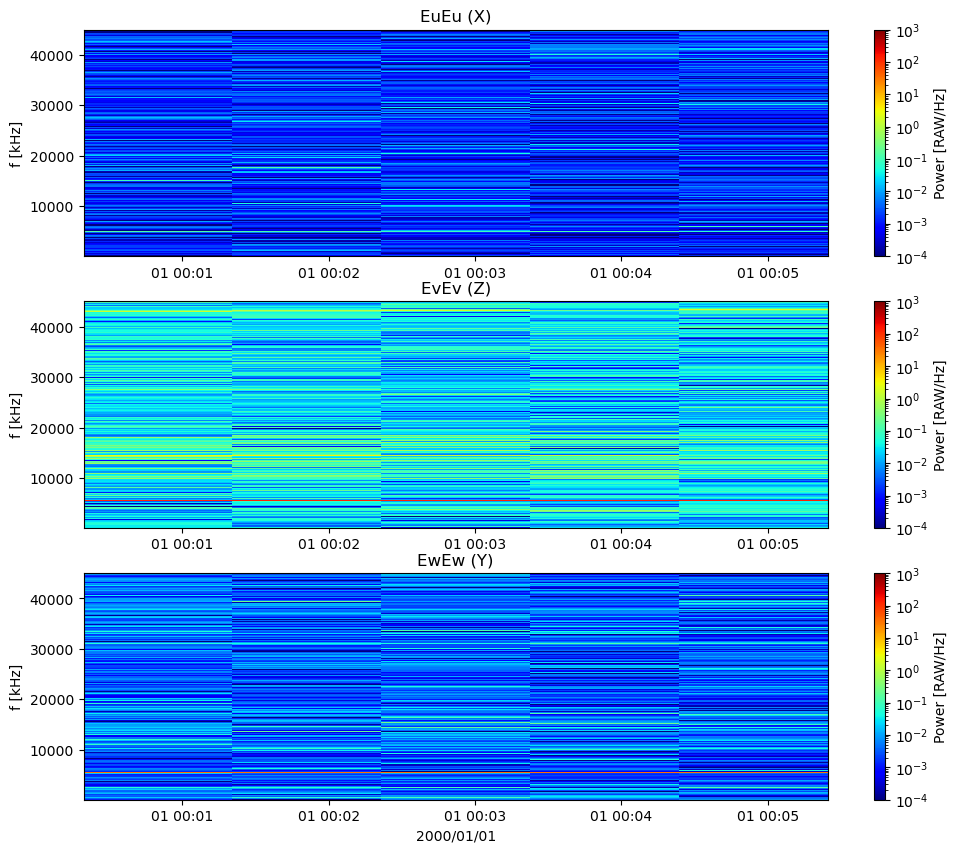

In [11]:
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

# Y-axis
ax1.set_ylim(f_min, f_max)
ax2.set_ylim(f_min, f_max)
ax3.set_ylim(f_min, f_max)
ax1.set_ylabel('f [kHz]')
ax2.set_ylabel('f [kHz]')
ax3.set_ylabel('f [kHz]')

# X-axis
ax1.set_title('EuEu (X)')
ax2.set_title('EvEv (Z)')
ax3.set_title('EwEw (Y)')
date = data.epoch[0]
date = date.strftime('%Y/%m/%d')
ax3.set_xlabel(date)

# Plot
p1 = ax1.pcolormesh(spec.epoch, spec.frequency, spec.Eu_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
p2 = ax2.pcolormesh(spec.epoch, spec.frequency, spec.Ev_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
p3 = ax3.pcolormesh(spec.epoch, spec.frequency, spec.Ew_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')

pp1 = fig.colorbar(p1, ax=ax1, orientation="vertical")
pp1.set_label(power_str)
pp2 = fig.colorbar(p2, ax=ax2, orientation="vertical")
pp2.set_label(power_str)
pp3 = fig.colorbar(p3, ax=ax3, orientation="vertical")
pp3.set_label(power_str)

png_fname = work_dir+data_name+'_FT-log.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_FT-log_h.png'
# fig.savefig(png_fname)

# Analyses

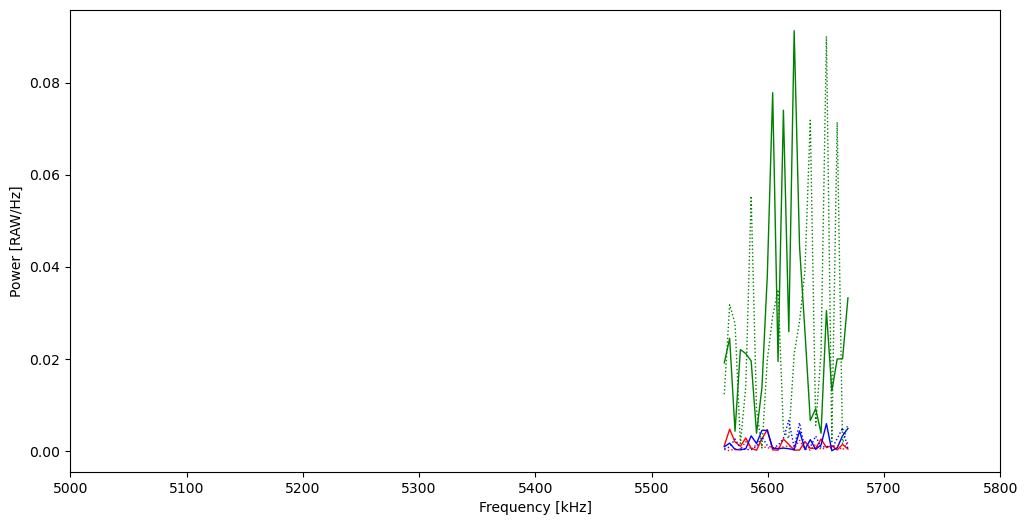

In [12]:
fig = plt.figure(figsize=(12, 6))

# plt.plot(spec.frequency[0:spec.n_step*spec.n_samp,0], spec.Eu_power[0:spec.n_step*spec.n_samp,0], '-r', linewidth=1)
n_samp = np.int16(spec.n_samp * 0.75)

for i in range(spec.n_step):
    if i>62 and i<64:
        plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,0], spec.Eu_power[i*n_samp:(i+1)*n_samp,0], '-r', linewidth=1)
        plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,0], spec.Ev_power[i*n_samp:(i+1)*n_samp,0], '-g', linewidth=1)
        plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,0], spec.Ew_power[i*n_samp:(i+1)*n_samp,0], '-b', linewidth=1)
        plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,n_time-1], spec.Eu_power[i*n_samp:(i+1)*n_samp,n_time-1], ':r', linewidth=1)
        plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,n_time-1], spec.Ev_power[i*n_samp:(i+1)*n_samp,n_time-1], ':g', linewidth=1)
        plt.plot(spec.frequency[i*n_samp:(i+1)*n_samp,n_time-1], spec.Ew_power[i*n_samp:(i+1)*n_samp,n_time-1], ':b', linewidth=1)

plt.xlabel('Frequency [kHz]')
# plt.xlim(f_min, f_max)
# plt.xlim(0, 1000)
plt.xlim(5000, 5800)

# plt.yscale('log')
plt.ylabel(power_str)
# plt.ylim(10**p_min, 10**p_max)

plt.show()
png_fname = work_dir+data_name+'_spec.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_spec_h.png'
fig.savefig(png_fname)

/var/folders/h3/4_tnwr0x0v9gcl5qc0vczzyr0000gn/T/ipykernel_1866/2514226611.py:27: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p1 = ax1.pcolormesh(spec.epoch, spec.frequency, spec.Eu_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
/var/folders/h3/4_tnwr0x0v9gcl5qc0vczzyr0000gn/T/ipykernel_1866/2514226611.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p2 = ax2.pcolormesh(spec.epoch, spec.frequency, spec.Ev_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
/var/folders/h3/4_tnwr0x0v9gcl5qc0vczzyr0000gn/T/ipykernel_1866/2514226611.p

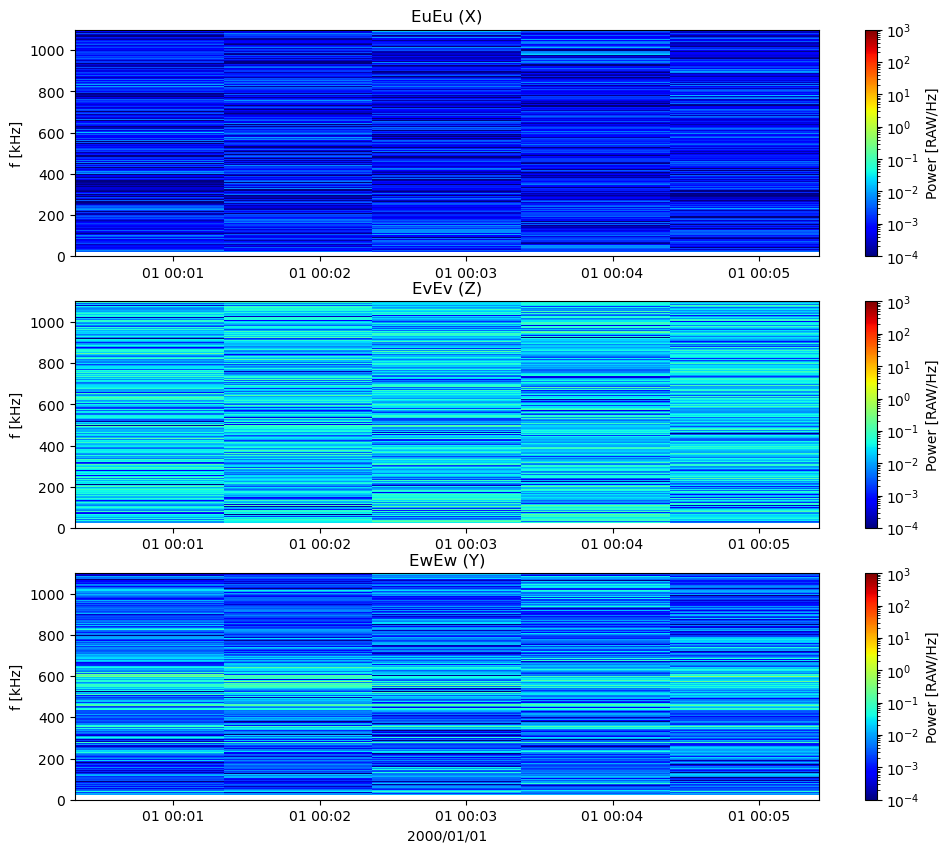

In [13]:
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

# Y-axis
# ax1.set_ylim(f_min, f_max)
# ax2.set_ylim(f_min, f_max)
# ax3.set_ylim(f_min, f_max)
ax1.set_ylim(000, 1100)
ax2.set_ylim(000, 1100)
ax3.set_ylim(000, 1100)
ax1.set_ylabel('f [kHz]')
ax2.set_ylabel('f [kHz]')
ax3.set_ylabel('f [kHz]')

# X-axis
ax1.set_title('EuEu (X)')
ax2.set_title('EvEv (Z)')
ax3.set_title('EwEw (Y)')
date = data.epoch[0]
date = date.strftime('%Y/%m/%d')
ax3.set_xlabel(date)

# Plot
p1 = ax1.pcolormesh(spec.epoch, spec.frequency, spec.Eu_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
p2 = ax2.pcolormesh(spec.epoch, spec.frequency, spec.Ev_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')
p3 = ax3.pcolormesh(spec.epoch, spec.frequency, spec.Ew_power, norm=colors.LogNorm(vmin=10**p_min, vmax=10**p_max), cmap='jet')

pp1 = fig.colorbar(p1, ax=ax1, orientation="vertical")
pp1.set_label(power_str)
pp2 = fig.colorbar(p2, ax=ax2, orientation="vertical")
pp2.set_label(power_str)
pp3 = fig.colorbar(p3, ax=ax3, orientation="vertical")
pp3.set_label(power_str)

png_fname = work_dir+data_name+'_FT-log.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_FT-log_h.png'
# fig.savefig(png_fname)

2000/01/01


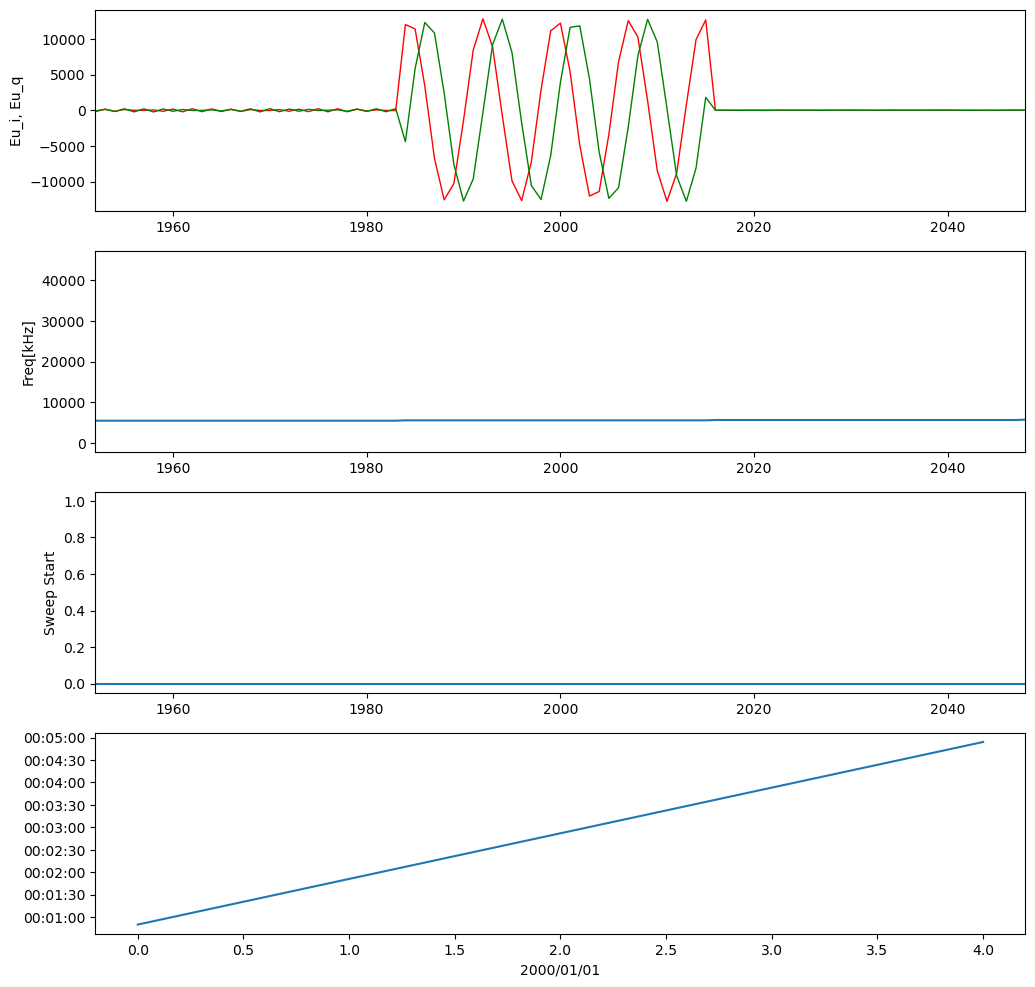

In [14]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2)
ax3 = fig.add_subplot(4, 1, 3)
ax4 = fig.add_subplot(4, 1, 4)

ax1.plot(np.ravel(data.Eu_i), '-r', linewidth=1)
ax1.plot(np.ravel(data.Eu_q), '-g', linewidth=1)
ax2.plot(np.ravel(data.frequency))
ax3.plot(np.ravel(data.sweep_start))
ax4.plot(np.ravel(data.epoch))
date = data.epoch[0]
date = date.strftime('%Y/%m/%d')
print(date)

ax1.set_ylabel('Eu_i, Eu_q')
ax2.set_ylabel('Freq[kHz]')
ax3.set_ylabel('Sweep Start')
ax4.set_xlabel(date)

xlim=[1952, 2048]
ax1.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_xlim(xlim)
plt.show()
png_fname = work_dir+data_name+'_raw.png'
fig.savefig(png_fname)
